<a href="https://www.kaggle.com/code/omershlomo/cheetah-hyena-jaguar-and-tiger-classification?scriptVersionId=117876380" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Importing our Data**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os, shutil
import torch
import albumentations as albu
from torchvision import datasets, models, transforms
from torchvision.models import resnet50
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torchvision.datasets import ImageFolder
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torchvision
import time
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix


%matplotlib inline
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Loading the Dataset and create Trainloader and Testloader over it and Finetuning**

In [2]:
input_path = "/kaggle/input/cheetahhyenajaguarandtigerv2/data/"

In [3]:

data_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])

    ]),
    'validation':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(input_path + 'valid', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

# **Create Grid over the pictures from the training Set**

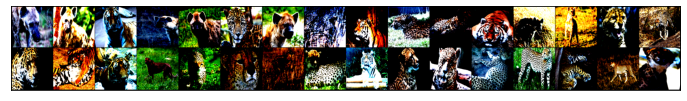

In [4]:
for images, labels in dataloaders['train']:
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

# **Prepare Resnet50 for Transfer Learning**

In [5]:
model  = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [6]:
# Freeze model parameters
for param in model.parameters():
    param.requires_grad = False

# **Change the head of the resnet50 for my dataset**

In [7]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = model .fc.in_features
model.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, 10), 
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

# **Hyperparameters**

In [8]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


lrs = []



In [9]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

527114

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
if torch.cuda.is_available():
    model.cuda()

# **Train my model over the Resnet50 pretrained**

In [12]:
num_epochs=5
train_losses,valid_losses=[],[]
train_accs,val_accs= [],[]
for epoch in range(num_epochs):
    print('Epoch[ {}/{} ]'.format(epoch+1, num_epochs))
    print('-' * 10)

    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])

        if phase=='train':
            train_losses.append(running_loss / len(image_datasets[phase]))
            train_accs.append(running_corrects.double() / len(image_datasets[phase])*100)

        else:
            valid_losses.append( running_loss / len(image_datasets[phase]))
            val_accs.append(running_corrects.double() / len(image_datasets[phase])*100)




        if phase=='train':
            print(f'\n'
                  f'Training Loss: {epoch_loss:.4f}\n'
                  f'Training Accuracy: {epoch_acc*100:.4f}\n')
        else:
            print(f'\n'
                  f'Validation Loss: {epoch_loss:.4f}\n'
                  f'Validation Accuracy: {epoch_acc*100:.4f}\n')





Epoch[ 1/5 ]
----------

Training Loss: 0.8817
Training Accuracy: 80.1667


Validation Loss: 0.2591
Validation Accuracy: 99.0000

Epoch[ 2/5 ]
----------

Training Loss: 0.2419
Training Accuracy: 96.2222


Validation Loss: 0.1038
Validation Accuracy: 99.5000

Epoch[ 3/5 ]
----------

Training Loss: 0.1381
Training Accuracy: 98.0000


Validation Loss: 0.0672
Validation Accuracy: 99.5000

Epoch[ 4/5 ]
----------

Training Loss: 0.1005
Training Accuracy: 98.0556


Validation Loss: 0.0504
Validation Accuracy: 99.5000

Epoch[ 5/5 ]
----------

Training Loss: 0.0839
Training Accuracy: 98.1667


Validation Loss: 0.0447
Validation Accuracy: 99.5000



In [13]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in dataloaders['validation']:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs
    torch.save(model, 'Omermodel.pth')
    print('Accuracy of the network on the {} test images: {} %'.format(400, 100 * correct / total))   

Accuracy of the network on the 400 test images: 99.5 %


# **Create a graph to show the traning of the loss from the Training set **

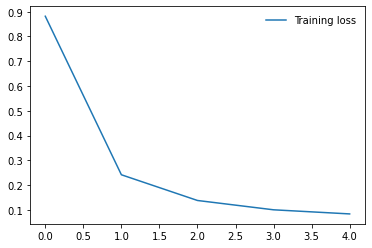

In [14]:
plt.plot(train_losses, label='Training loss')
plt.legend(frameon=False)
plt.show()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# **Create a graph to show the Training Accuracy and Validation Accuracy **

In [16]:
train_accs=[train_accs[i].tolist() for i in range(len(train_accs))]
val_accs=[val_accs[i].tolist() for i in range(len(train_accs))]

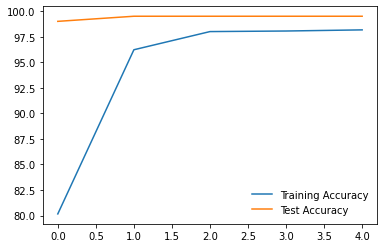

In [17]:

plt.plot(train_accs, label='Training Accuracy')
plt.plot(val_accs, label='Test Accuracy')
plt.legend(frameon=False)
plt.show()

In [18]:
data_dir = '/kaggle/input/cheetahhyenajaguarandtigerv2/data/train'


test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('Omermodel.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# **Preparing images to show how our model trained and which pictures its predicte**

In [20]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

In [21]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    
    return index

# **Random predictions**

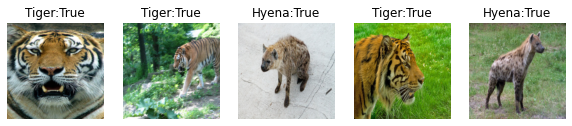

In [22]:
class_names = ['Cheetah','Hyena', 'Jaguar',  'Tiger']

to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = int(labels[ii]) == index
    sub.set_title(str(class_names[index]) + ":" + str(res))
    plt.axis('off')
    plt.imshow(image)
plt.show()

In [23]:

def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)


# **Confusion matrix**

In [24]:

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusioDn matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [26]:
@torch.no_grad()
def get_all_prediction(model, loader):
    preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        batch_predictions = model(images)
        preds = torch.cat((preds, batch_predictions), dim = 0)
    return preds

In [27]:
if torch.cuda.is_available():
    model.cuda()

In [28]:
y_true = []
y_pred = []

for data in tqdm(dataloaders['validation']):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())

  outputs=model(images)

  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

100%|██████████| 13/13 [00:03<00:00,  3.76it/s]


In [29]:
cf_matrix = confusion_matrix(y_true, y_pred)

In [30]:
class_names = {'Cheetah','Hyena' , 'Jaguar', 'Tiger'}

# Create pandas dataframe
dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
dataframe

,Hyena,Cheetah,Jaguar,Tiger
Hyena,98,1,1,0
Cheetah,0,100,0,0
Jaguar,0,0,100,0
Tiger,0,0,0,100


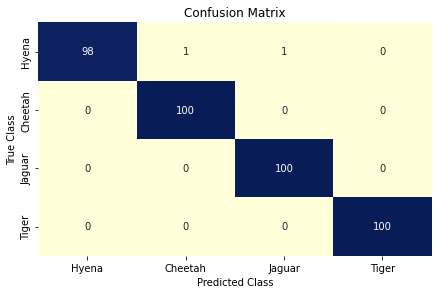

In [31]:
import seaborn as sns
sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

# **Wrong predictions**

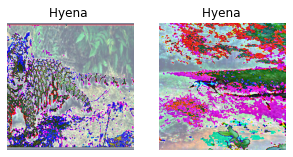

In [32]:
model.eval()
test_loss = 0
correct = 0
lst=[]
fig=plt.figure(figsize=(5,5))
with torch.no_grad():
    for data, target in dataloaders['validation']:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        # Store wrongly predicted images
        wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
        wrong_samples = data[wrong_idx]
        wrong_preds = pred[wrong_idx]
        actual_preds = target.view_as(pred)[wrong_idx]
#         wrong_idx = wrong_idx.tolist()
        wrong_idx=[wrong_idx[i].tolist() for i in range(len(wrong_idx.tolist())) if wrong_idx[i] != []]
        a_pred=actual_preds.tolist()
        w_pred=wrong_preds.tolist()
        for i in range(len(wrong_preds)):
            sample = wrong_samples[i]
            wrong_pred = wrong_preds[i]
            actual_pred = actual_preds[i]
            # Undo normalization
            sample = sample * 0.3081
            sample = sample + 0.1307
            sample = sample * 255.
            sample = sample.byte()
            to_pil = transforms.ToPILImage()
            img = to_pil(sample)
            class_names = ['Cheetah','Hyena', 'Jaguar',  'Tiger']
            index = predict_image(img)
            sub = fig.add_subplot(1, len(wrong_idx), i+1)
            sub.set_title(f'{str(class_names[index])} ')
            plt.axis('off')
            plt.imshow(img)
        plt.show()

